In [18]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from matplotlib.patches import Patch

In [19]:
def rename_keys_by_map(d, key_map):
    """
    Renames keys in a dictionary using a mapping from old to new keys.

    Args:
        d (dict): Original dictionary.
        key_map (dict): Mapping from old keys to new keys.

    Returns:
        dict: Dictionary with renamed keys.
    """
    return {key_map.get(k, k): v for k, v in d.items()}

def reorder_dict(d, key_order):
    """
    Returns a new dict with keys ordered as specified in key_order.

    Args:
        d (dict): The original dictionary.
        key_order (list): Desired order of keys.

    Returns:
        dict: Reordered dictionary.
    """
    return {k: d[k] for k in key_order if k in d}

In [20]:
data_path = '/Users/ebrahimfeghhi/Documents/neurips_2025/local_results/paper_results/'

In [30]:
with open(data_path + 'blue_bar_comp.pkl', 'rb') as f:
    main_results = pickle.load(f)
    
with open(data_path + 'blue_bar_val.pkl', 'rb') as f:
    main_results_val = pickle.load(f)
    
with open(data_path + 'grey_bar_comp.pkl', 'rb') as f:
    ablation_results = pickle.load(f)
    
with open(data_path + 'grey_bar_dict.pkl', 'rb') as f:
    ablation_results_val = pickle.load(f)
    
main_results['neurips_gru_data_log_time_masked_lr_schedule_seed_'].append(12.586) # missing seed, reran
main_results['neurips_gru_baseline_seed_seed_'].append(16.362)


In [31]:
1 - np.mean(main_results['neurips_transformer_time_masked_seed_']) / np.mean(main_results['neurips_gru_baseline_seed_seed_'])

0.202404939876503

In [32]:
1 - np.mean(main_results['neurips_gru_data_log_time_masked_lr_schedule_seed_'])/np.mean(main_results['neurips_gru_baseline_seed_seed_'])

0.18524536886577836

In [33]:
main_results.keys()
remapped_keys_main = {'neurips_gru_baseline_seed_seed_': 'GRU (Baseline)', 
                 'neurips_gru_datalog_lr_scheduler_seed_': '+ LR↓ + Log(x)', 
                 'neurips_gru_data_log_time_masked_lr_schedule_seed_': '+ Mask',
                 'neurips_transformer_time_masked_seed_': 'GRU → Transformer'}
model_perf_dict_main = rename_keys_by_map(main_results, remapped_keys_main)

key_to_switch_ablation = ['No Log(x)', 'No LR↓', 'Sinusoidal Pos. Emb.', 'No Mask']
orig_ablation_keys = list(ablation_results_val.keys())
remapped_keys_ablation = {}
for new_key, old_key in zip(key_to_switch_ablation, orig_ablation_keys):
    remapped_keys_ablation[old_key] = new_key

model_perf_dict_ablate = rename_keys_by_map(ablation_results, remapped_keys_ablation)


In [34]:
from scipy.stats import sem  # standard error of the mean
for model_name, values in model_perf_dict_main.items():
    values = np.array(values)
    mean_val = np.mean(values)
    sem_val = sem(values)
    print(f"{model_name}: {mean_val:.2f} ± {sem_val:.2f}")
    
# Pairwise t-tests without correction
print("\nPairwise t-tests (no correction):")
alpha = 0.05

from itertools import combinations
from scipy.stats import sem, ttest_ind
all_models = list(model_perf_dict_main.keys())
for model1, model2 in combinations(all_models, 2):
    values1 = np.array(model_perf_dict_main[model1])
    values2 = np.array(model_perf_dict_main[model2])
    t_stat, p_val = ttest_ind(values1, values2, equal_var=False)  # Welch's t-test
    significance = "✓" if p_val < alpha else "✗"
    print(f"{model1} vs {model2}: p = {p_val:.4g} ({significance})")

GRU (Baseline): 15.38 ± 0.18
+ LR↓ + Log(x): 15.24 ± 0.08
+ Mask: 12.54 ± 0.12
GRU → Transformer: 12.27 ± 0.15

Pairwise t-tests (no correction):
GRU (Baseline) vs + LR↓ + Log(x): p = 0.4587 (✗)
GRU (Baseline) vs + Mask: p = 5.798e-10 (✓)
GRU (Baseline) vs GRU → Transformer: p = 1.23e-10 (✓)
+ LR↓ + Log(x) vs + Mask: p = 1.623e-12 (✓)
+ LR↓ + Log(x) vs GRU → Transformer: p = 1.079e-10 (✓)
+ Mask vs GRU → Transformer: p = 0.1847 (✗)


In [15]:
from scipy.stats import sem  # standard error of the mean
original_perf = 12.27
for model_name, values in model_perf_dict_ablate.items():
    values = np.array(values)
    mean_val = np.mean(values)
    sem_val = sem(values)
    print(f"{model_name}: {mean_val:.2f} ± {sem_val:.2f}")
    
    print(f"{model_name}: {(mean_val - original_perf)/original_perf}")


No Log(x): 13.50 ± 0.10
No Log(x): 0.10022412387938069
Sinusoidal Pos. Emb.: 15.22 ± 0.53
Sinusoidal Pos. Emb.: 0.2405664221678892
No LR↓: 13.60 ± 0.30
No LR↓: 0.10821108394458043
No Mask: 19.46 ± 0.17
No Mask: 0.5857986960065201


# Figure 1

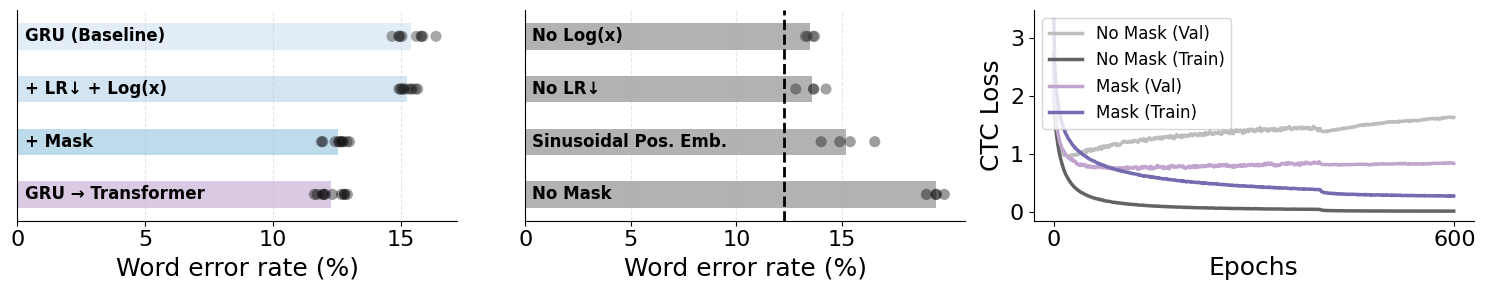

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import to_rgba

np.random.seed(0)

# -----------------------------
# Data for main models
# -----------------------------
model_order_main = list(model_perf_dict_main.keys())

data_main = pd.DataFrame([
    {"Model": m, "Performance": p} for m, ps in model_perf_dict_main.items() for p in ps
])
data_main["Model"] = pd.Categorical(data_main["Model"], categories=model_order_main, ordered=True)
means_main = data_main.groupby("Model", observed=False)["Performance"].mean().reset_index()



# -----------------------------
# Data for ablations
# -----------------------------
model_order_ablate = ['No Log(x)', 'No LR↓', 'Sinusoidal Pos. Emb.', 'No Mask']
data_ablate = pd.DataFrame([
    {"Model": m, "Performance": p} for m, ps in model_perf_dict_ablate.items() for p in ps
])
data_ablate["Model"] = pd.Categorical(data_ablate["Model"], categories=model_order_ablate, ordered=True)
means_ablate = data_ablate.groupby("Model", observed=False)["Performance"].mean().reset_index()

# -----------------------------
# Plotting
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=False, sharey=False)
bar_color = "#6baed6"
colors = cm.Blues(np.linspace(0.2, 0.5, 4))
colors[-1] = to_rgba("#c2a5cf") 
# ---- Main models plot ----
for i, row in means_main.iterrows():
    axes[0].barh(
        y=row["Model"],
        width=row["Performance"],
        color=colors[i],
        alpha=0.6,
        height=0.5,
        zorder=0,
    )
    axes[0].text(
        0.3,
        row["Model"],
        row["Model"],
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        weight='bold',
        zorder=3,
    )

sns.stripplot(
    data=data_main,
    y="Model",
    x="Performance",
    order=model_order_main,
    hue="Model",
    palette='dark:black',
    jitter=False,
    size=8,
    alpha=0.4,
    legend=False,
    zorder=2,
    ax=axes[0],
)

axes[0].set_title("", fontsize=16, pad=8)
axes[0].set_xlabel("Word error rate (%)", fontsize=18)
axes[0].set_ylabel("")
axes[0].tick_params(labelsize=12)
axes[0].set_xlim(left=0)
axes[0].set_xticks([0, 5, 10, 15])
axes[0].grid(axis="x", linestyle="--", alpha=0.3)
sns.despine(left=True, ax=axes[0])

# ---- Ablation plot ----
for _, row in means_ablate.iterrows():
    axes[1].barh(
        y=row["Model"],
        width=row["Performance"],
        color='gray',
        alpha=0.6,
        height=0.5,
        zorder=0,
    )
    axes[1].text(
        0.3,
        row["Model"],
        row["Model"],
        va='center',
        ha='left',
        fontsize=12,
        color='black',
        weight='bold',
        zorder=3,
    )

sns.stripplot(
    data=data_ablate,
    y="Model",
    x="Performance",
    order=model_order_ablate,
    hue="Model",
    palette='dark:black',
    jitter=False,
    size=8,
    alpha=0.4,
    legend=False,
    zorder=2,
    ax=axes[1],
)

axes[1].set_title("", fontsize=16, pad=8)
axes[1].set_xlabel("Word error rate (%)", fontsize=18)
axes[1].set_ylabel("")
axes[1].set_xlim(left=0)
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[1].set_xticks([0, 5, 10, 15])
axes[1].tick_params(axis='both', labelsize=16)
axes[0].tick_params(axis='both', labelsize=16)
axes[1].grid(axis="x", linestyle="--", alpha=0.3)
axes[1].axvline(x=np.mean(model_perf_dict_main['GRU → Transformer']), 
                color="black", linestyle='--', linewidth=2)
sns.despine(left=True, ax=axes[1])





# Load Excel file
file_path = "/Users/ebrahimfeghhi/Documents/neurips_2025/local_results/train_val_time_mask.xlsx"
df = pd.read_excel(file_path)

# Define custom colors: lighter for train, darker for val
custom_palette = {
    "No Mask (Train)": "#636363",  # light gray
    "No Mask (Val)": "#bdbdbd",    # dark gray
    "Mask (Train)": "#756bb1",     # light purple
    "Mask (Val)": "#c2a5cf"        # dark purple
}


# Melt into long format for seaborn
df_long = df.reset_index().melt(id_vars="index", var_name="", value_name="Loss")

# Plot with custom palette and solid lines
sns.lineplot(data=df_long, x="index", y="Loss", hue="", palette=custom_palette, style=None, linewidth=2.5)
sns.despine()
axes[2].set_xticks([0, 600])
axes[2].tick_params(axis='both', labelsize=16)
axes[2].set_yticks([0, 1, 2, 3])
axes[2].legend(fontsize=12)
axes[2].set_xlabel("Epochs", fontsize=18)
axes[2].set_ylabel("CTC Loss", fontsize=18)
#plt.savefig('/Users/ebrahimfeghhi/Documents/neurips_2025/local_figures/figure2/tm_overfit.pdf', bbox_inches='tight')


plt.savefig('/Users/ebrahimfeghhi/Documents/neurips_2025/local_figures/figure2/3_gram.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [58]:
import pickle 


PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

basePath_phonemes = '/Users/ebrahimfeghhi/Documents/neurips_2025/local_results/phoneme_matrix/'

model = 'gru'

with open(f"{basePath_phonemes}decoded_seqs_gru.pkl", 'rb') as f:
    decoded_seqs_gru = pickle.load(f)
    
with open(f"{basePath_phonemes}true_seqs_gru.pkl", 'rb') as f:
    true_seqs_gru = pickle.load(f)
    
    
with open(f"{basePath_phonemes}decoded_seqs_transformer.pkl", 'rb') as f:
    decoded_seqs_tf = pickle.load(f)
    
with open(f"{basePath_phonemes}true_seqs_transformer.pkl", 'rb') as f:
    true_seqs_tf= pickle.load(f)

In [112]:
def create_phone_matrix(decoded_seqs, true_seqs):
    
    p = set()
    for i in range(len(decoded_seqs)):
        for j in range(len(decoded_seqs[i])):
            p.add(decoded_seqs[i][j])
    from difflib import SequenceMatcher
    from collections import Counter

    # Assume these are your datasets:
    # Each is a list of lists of integers
    # For example:
    # decoded_sequences = [[1, 2, 3], [4, 5, 6]]
    # ground_truth_sequences = [[1, 2, 4], [4, 7, 6]]

    decoded_sequences = decoded_seqs        # List of 880 decoded sequences (predicted)
    ground_truth_sequences = true_seqs   # List of 880 ground-truth sequences

    # Error counters
    substitution_counter = Counter()
    insertion_counter = Counter()
    deletion_counter = Counter()

    # Process each sequence pair
    for gt_seq, pred_seq in zip(ground_truth_sequences, decoded_sequences):
        matcher = SequenceMatcher(None, gt_seq, pred_seq)
        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag == 'replace':
                for gt, pred in zip(gt_seq[i1:i2], pred_seq[j1:j2]):
                    substitution_counter[(gt, pred)] += 1
            elif tag == 'insert':
                for pred in pred_seq[j1:j2]:
                    insertion_counter[pred] += 1
            elif tag == 'delete':
                for gt in gt_seq[i1:i2]:
                    deletion_counter[gt] += 1
                    
    print("Total substitutions:", sum(substitution_counter.values()))
    print("Total deletions:", sum(deletion_counter.values()))
    print("Total insertions:", sum(insertion_counter.values()))

    # Example outputs
    #print("Top Substitution Errors:")
    #for (gt, pred), count in substitution_counter.most_common(10):
    #    print(f"{PHONE_DEF_SIL[gt - 1]} -> {PHONE_DEF_SIL[pred - 1]}: {count}")

    #print("\nTop Insertions:")
    #for phoneme, count in insertion_counter.most_common(10):
    #    print(f"{PHONE_DEF_SIL[phoneme - 1]} (inserted): {count}")

    #print("\nTop Deletions:")
    #for phoneme, count in deletion_counter.most_common(10):
    #    print(f"{PHONE_DEF_SIL[phoneme - 1]} (missing): {count}")

    phoneme_order = ['P', 'B', 'M', 'F', 'V', 'TH', 'DH', 'T', 'D', 'N', 'S', 'Z', 'CH', 'JH', 'SH', 'ZH', 'NG', 'K', 'G', 'Y', 'L', 'R', 'W', 'HH', 'OY', 'OW', 'AO', 'AA', 'AW', 'AY', 'AE',
                    'EH', 'EY', 'IY', 'IH', 'AH', 'UW', 'ER', 'UH', 'SIL']


    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from collections import Counter

    all_gt_ids = set(gt for gt, _ in substitution_counter)
    all_pred_ids = set(pred for _, pred in substitution_counter)
    all_ids = sorted(all_gt_ids.union(all_pred_ids))

    # Create empty DataFrame with proper phoneme labels
    phoneme_labels = [PHONE_DEF_SIL[i - 1] for i in all_ids]  # Apply the -1 mapping
    heatmap_df = pd.DataFrame(
        0, index=phoneme_labels, columns=phoneme_labels
    )

    # Fill the DataFrame with counts
    for (gt, pred), count in substitution_counter.items():
        gt_label = PHONE_DEF_SIL[gt - 1]
        pred_label = PHONE_DEF_SIL[pred - 1]
        heatmap_df.at[gt_label, pred_label] = count

    heatmap_df = heatmap_df.reindex(index=phoneme_order[::-1], columns=phoneme_order)
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_df,
        # annot=True,
        fmt='d',
        cmap='viridis',
        linewidths=0.001,
        linecolor='gray',
        vmin=0,
        vmax=44,
    )
    #plt.title("Phoneme Substitution Heatmap")
    #plt.xlabel("Predicted Phoneme")
    #plt.ylabel("Ground Truth Phoneme")
    # plt.xticks(rotation=90)
    plt.yticks(rotation=0, fontsize=12)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return heatmap_df


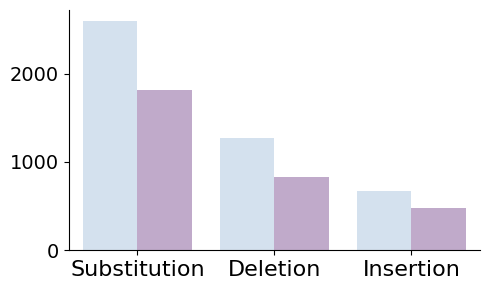

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = [
    {"Model": "GRU", "Error Type": "Substitution", "Count": 2589},
    {"Model": "GRU", "Error Type": "Deletion", "Count": 1268},
    {"Model": "GRU", "Error Type": "Insertion", "Count": 667},
    {"Model": "Transformer", "Error Type": "Substitution", "Count": 1811},
    {"Model": "Transformer", "Error Type": "Deletion", "Count": 830},
    {"Model": "Transformer", "Error Type": "Insertion", "Count": 478},
]

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df, x="Error Type", y="Count", hue="Model",
            palette={"Transformer": colors[-1], "GRU": colors[0]})

plt.ylabel("Error Count")
plt.xlabel("Error Type")
plt.title("Error Type Breakdown by Model")
plt.legend().remove()
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontsize=16)
plt.yticks([0, 1000, 2000], fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig('/Users/ebrahimfeghhi/Documents/neurips_2025/local_figures/figure2/substitution.pdf', bbox_inches='tight')
plt.show()


Total substitutions: 2589
Total deletions: 1268
Total insertions: 667


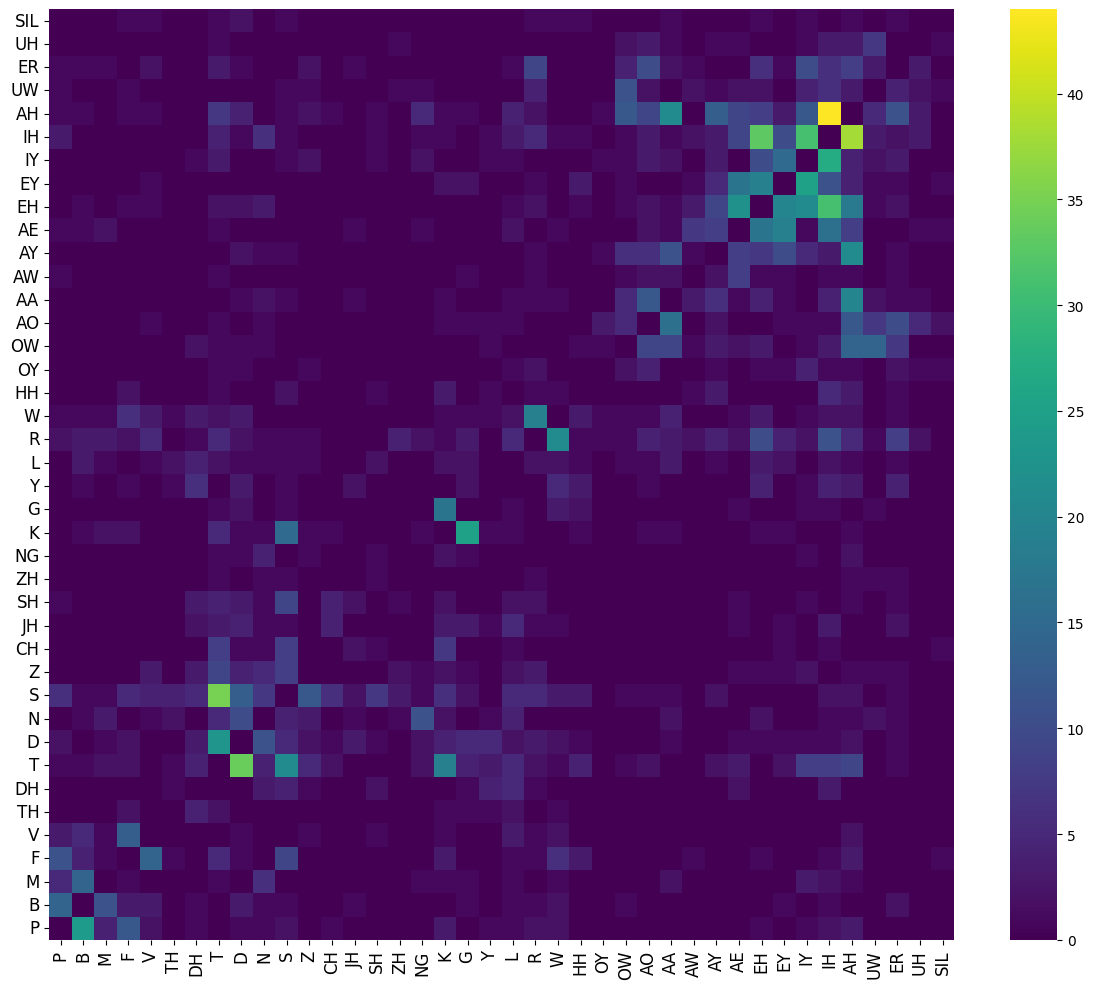

ValueError: too many values to unpack (expected 2)

In [114]:
gru_seqs, substitution_counter_gru = create_phone_matrix(decoded_seqs_gru, true_seqs_gru)

Total substitutions: 1811
Total deletions: 830
Total insertions: 478


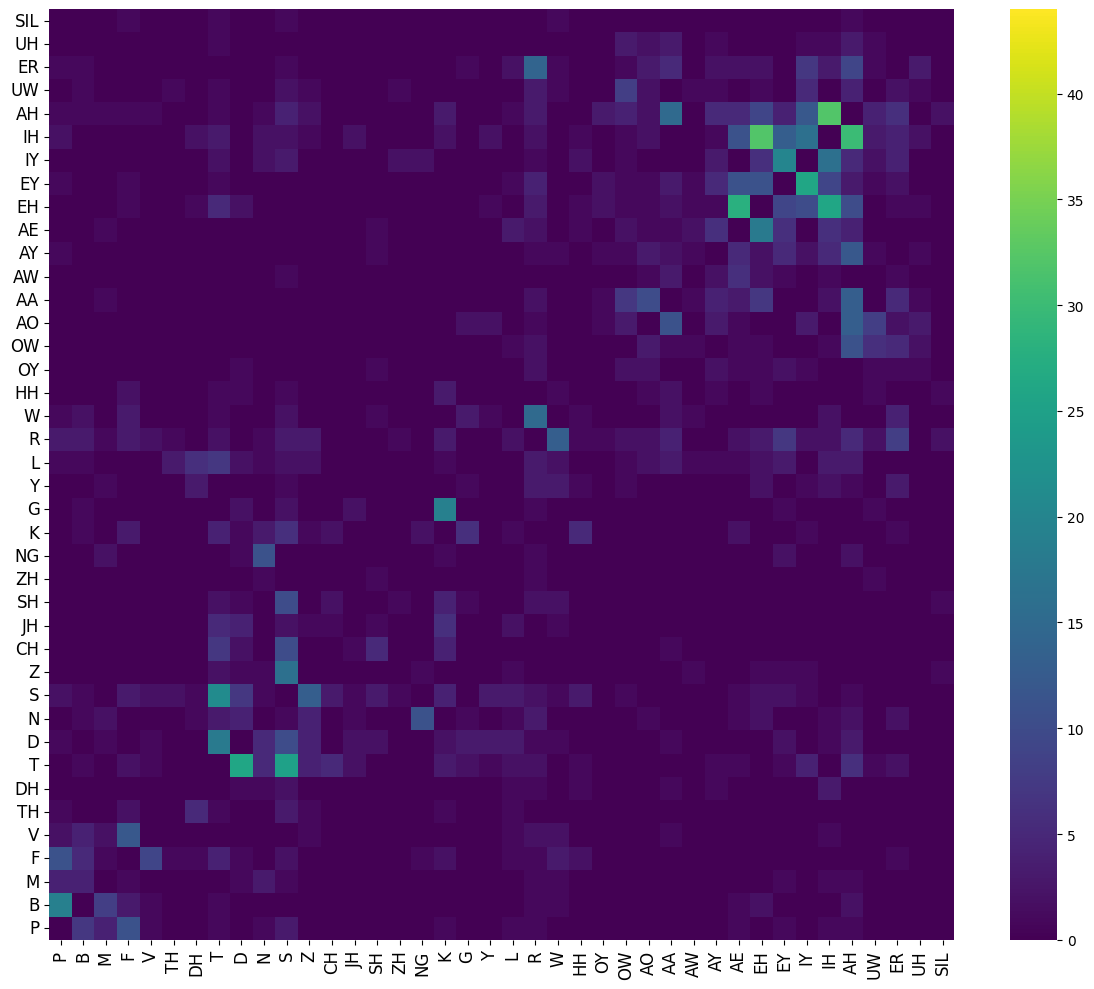

In [115]:
trans_seqs = create_phone_matrix(decoded_seqs_tf, true_seqs_tf)

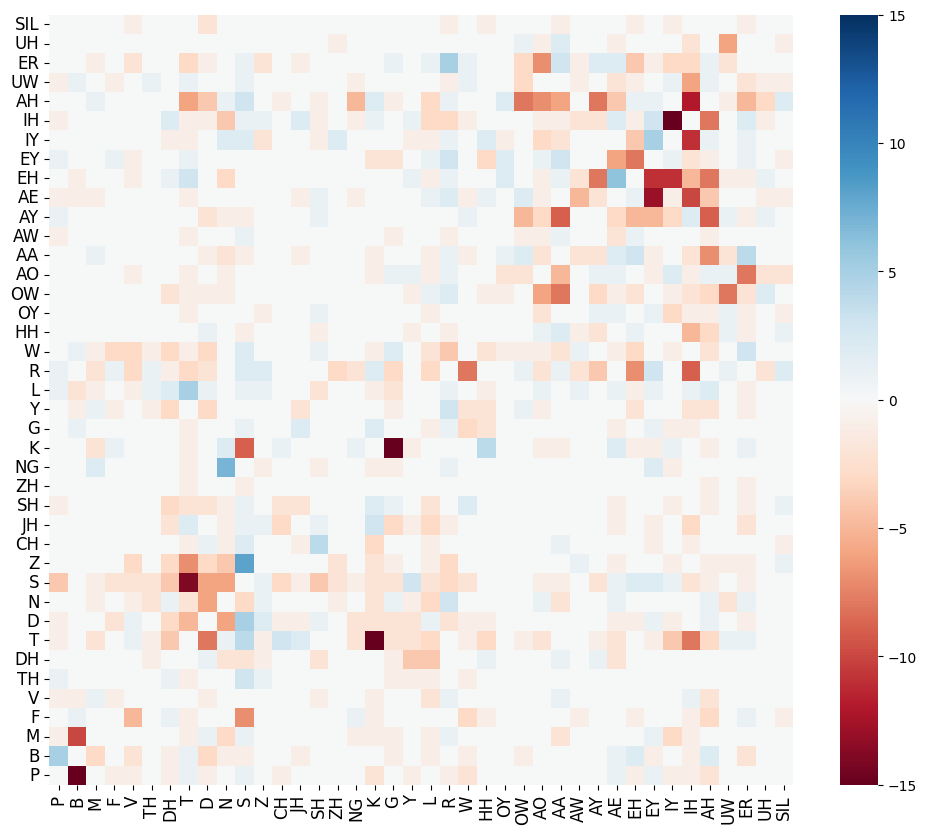

In [117]:
difference = trans_seqs - gru_seqs
plt.figure(figsize=(12, 10))
sns.heatmap(
    difference,
    # annot=True,
    fmt='d',
    cmap='RdBu',
    linewidths=0.001,
    linecolor='gray',
    vmin=-15,
    vmax=15
)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('/Users/ebrahimfeghhi/Documents/neurips_2025/local_figures/figure2/substitution_matrix.pdf', bbox_inches='tight')